In [68]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Load and process metering data (netload forecast)

In [69]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [70]:
nb_houses = 20

In [71]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


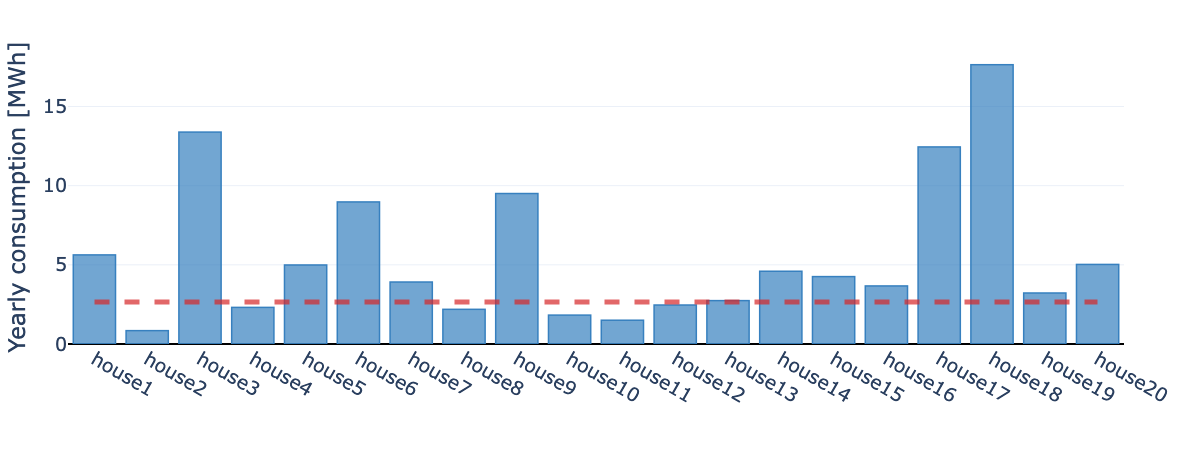

In [72]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    autosize=False,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [73]:
df = df[['2000964', 'pv_1kw']].copy()
df.columns = ["netload_kw", "ghi"]

pv_size = 3
df['netload_kw'] -= pv_size * df["ghi"]

In [74]:
# Interval of time series (e.g., shift training and prediction)
deltat = timedelta(minutes=15)

# Training end --> prediction start deltat after
end_training = datetime(2019, 5, 30, 0, 0, 0) - deltat
training = timedelta(days=31) - timedelta(days=1)  # 1 day for lagged varaibles

# Training start (make sure data available before for lagged values)
start_training = end_training - training + timedelta(days=1)

df = df.loc[end_training - training:end_training + timedelta(days=8)]

# Explore data

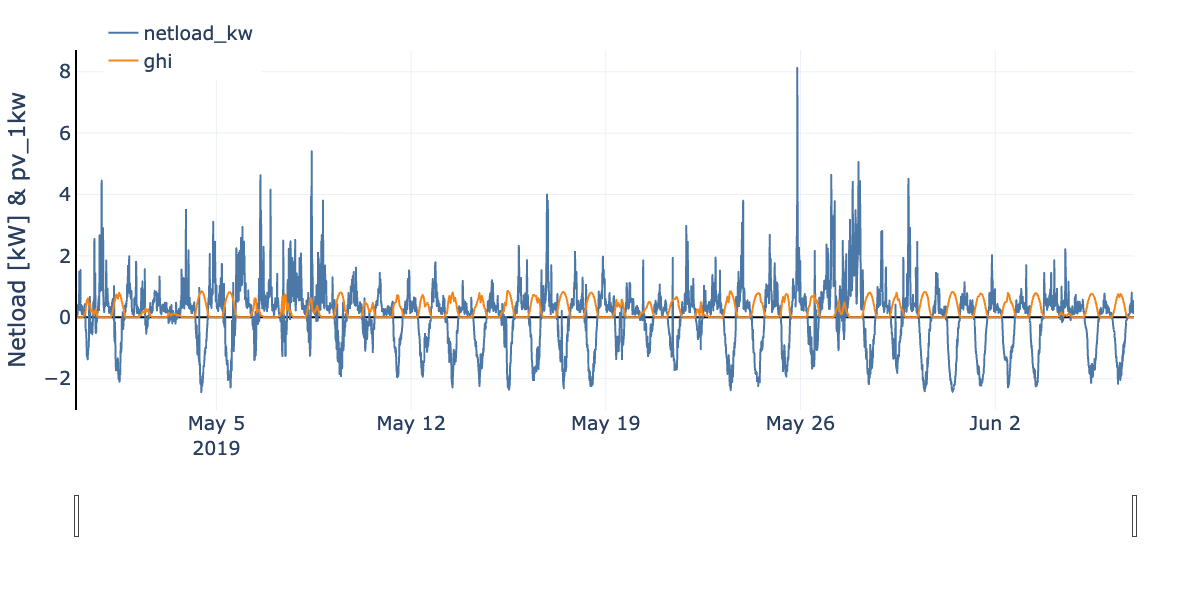

In [75]:
fig = px.line(df)
fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend={"x": 0.025, "y": 1.1},
    legend_title="",
    xaxis_title="",
    yaxis_title="Netload [kW] & pv_1kw",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0, xaxis_rangeslider_visible=True)
fig.show()

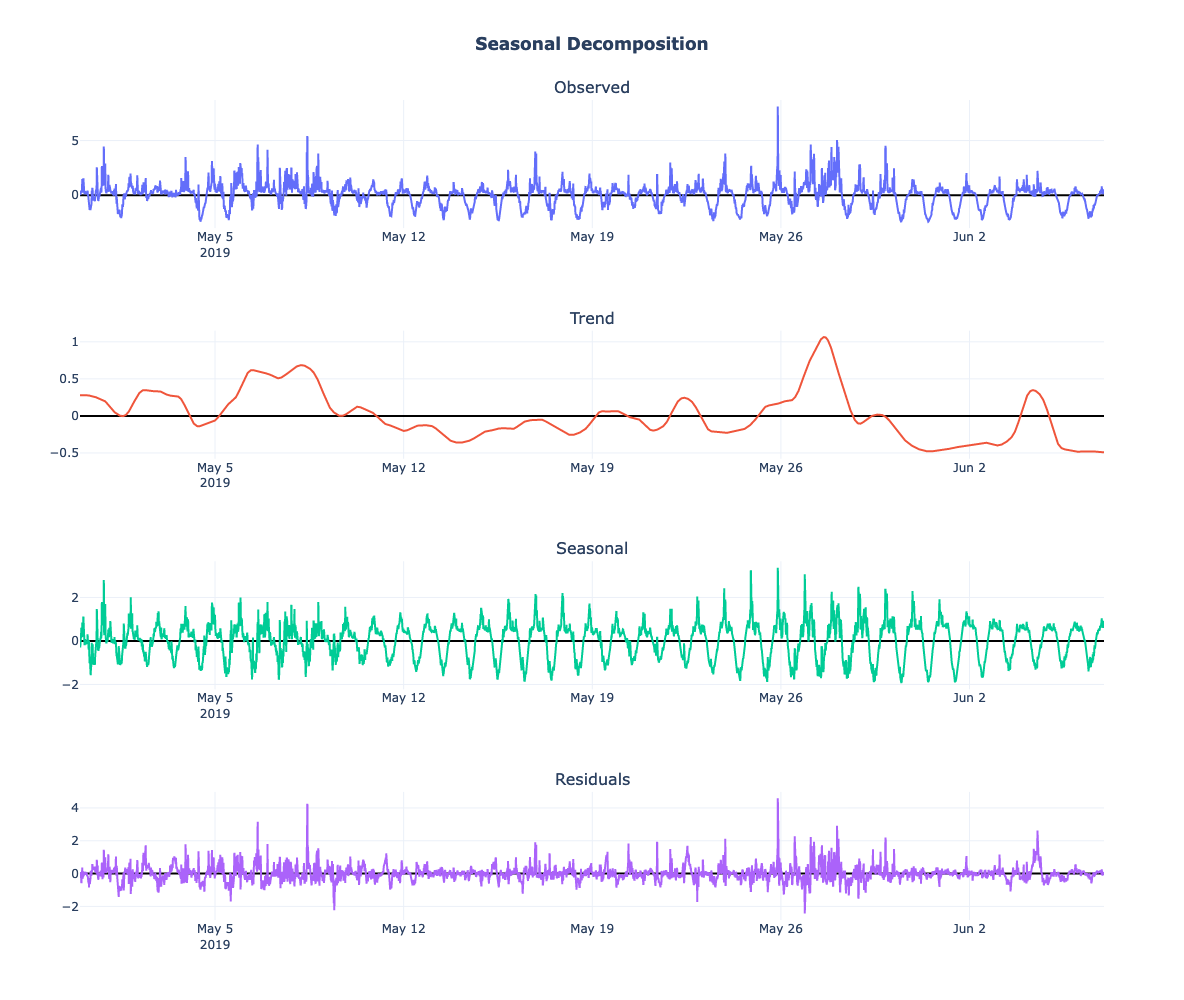

In [76]:
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
from plotly.subplots import make_subplots

res = STL(df.netload_kw.values, period=24*4).fit()
def plot_seasonal_decompose(result, dates, title="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            template="plotly_white",
            height=1000, width=1000,
            title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False,
            xaxis_zerolinewidth=2, xaxis_zerolinecolor="black",
            yaxis_zerolinewidth=2, yaxis_zerolinecolor="black",
            xaxis2_zerolinewidth=2, xaxis2_zerolinecolor="black",
            yaxis2_zerolinewidth=2, yaxis2_zerolinecolor="black",
            xaxis3_zerolinewidth=2, xaxis3_zerolinecolor="black",
            yaxis3_zerolinewidth=2, yaxis3_zerolinecolor="black",
            xaxis4_zerolinewidth=2, xaxis4_zerolinecolor="black",
            yaxis4_zerolinewidth=2, yaxis4_zerolinecolor="black",
        )
    )
fig = plot_seasonal_decompose(res, df.index, title="Seasonal Decomposition")
fig.show()

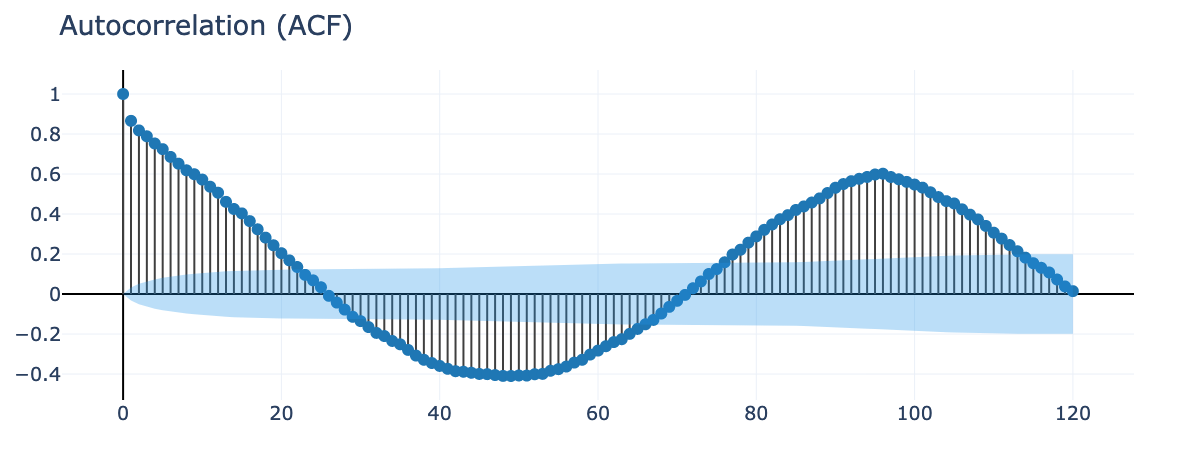

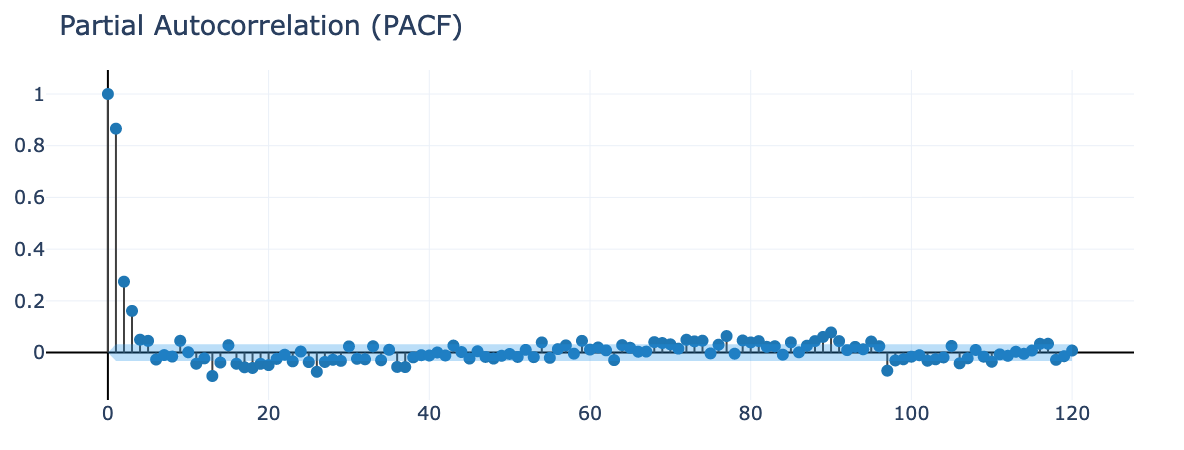

In [77]:
from statsmodels.tsa.stattools import pacf, acf
import plotly.graph_objects as go

def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series, alpha=0.05, nlags=30*4) if plot_pacf else acf(series, alpha=0.05, nlags=30*4)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(layout, autosize=False, margin_b=50, margin_t=70,
                      width=900, title=title)
    return fig
    
fig = create_corr_plot(df.netload_kw, plot_pacf=False)
fig.show()
fig = create_corr_plot(df.netload_kw, plot_pacf=True)
fig.show()

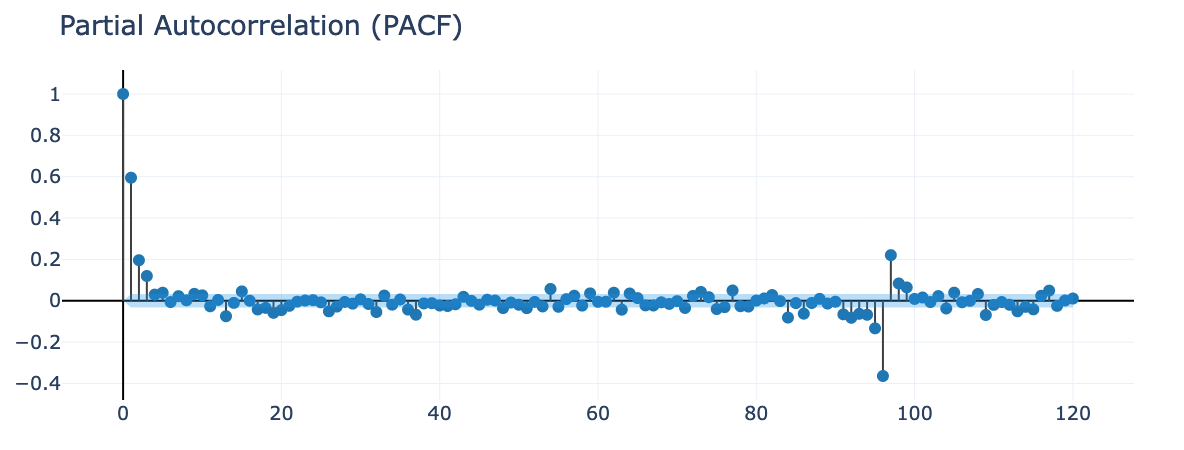

In [78]:
fig = create_corr_plot(res.resid, plot_pacf=True)
fig.show()

# GAM (a.k.a. Prophet) model

In [95]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None, 
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0,
                 uncertainty_samples=False,
                 reccord_raw=False):
        
        self._output = output
        self._model = Prophet(
            growth="flat",
            yearly_seasonality=False,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=uncertainty_samples,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"], 
                prior_scale=reg["prior_scale"])
        
        self.reccord_raw = reccord_raw
        if self.reccord_raw:
            self.raw = pd.DataFrame()

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        if self.reccord_raw:
            self.raw = pd.concat([self.raw, forecast])
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


https://fr.mathworks.com/help/ident/ref/goodnessoffit.html
NRMSE express between 0% and 100%

$$gof = 1 - \frac{L_2(target_i - pred_i)}{L_2(target_i - mean(target_i))}$$

In [80]:
def get_gof(df, result):
    pred = result.loc[:, ["netload_kw"]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], ["netload_kw"]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

# No autoreggressors

In [81]:
def predict_n_periods_T(
    df, start_training, end_training, 
    horizon, deltat, nb_period, regressors=[],
    daily_seasonality="auto", seasonality_prior_scale=10.0):
    
    results = pd.DataFrame()
    inputs = [reg["name"] for reg in regressors]
    model = GAM("netload_kw", regressors, daily_seasonality, seasonality_prior_scale)
    model.fit(df.loc[start_training:end_training])
    start_prediction = end_training
    #print(f"Trained from {start_training.date()} to {end_training}")
    
    for i in range(0, nb_period):
        # Move delta after end last prediction/training
        start_prediction += deltat
        end_prediction = start_prediction + horizon
        
        res = model.predict(df.loc[start_prediction:end_prediction, inputs])
        results = pd.concat([results, res], axis=0)

        #print(f"Predicted from {start_prediction} to {end_prediction.time()}")
        start_prediction = end_prediction
    return results

# With autoreggressors

In [82]:
from tqdm.notebook import tqdm

def lag_values(df, nb_lag):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp["netload_kw"].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(
        df, start_training, end_training, horizon,
        deltat, nb_horizon, regressors, nb_lag,
        daily_seasonality="auto", seasonality_prior_scale=10.0,
        uncertainties=False, disable_progress_bar=False, reccord_raw=False):
    
    results = []
    inputs = [reg["name"] for reg in regressors]
    model = GAM("netload_kw", regressors, daily_seasonality, seasonality_prior_scale,
                uncertainty_samples=uncertainties, reccord_raw=reccord_raw)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag)
    model.fit(tmp.loc[start_training:end_training])
    
    start_predictions = [end_training + deltat + i * (horizon + deltat) for i in range(0, nb_horizon)]
    for start_prediction in tqdm(start_predictions, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon
        
        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.loc[step, f"t-{n}"]):
                    tmp.loc[step, f"t-{n}"] = tmp_results[step_i-n]
            
            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, "netload_kw"])
            
        results.append(pd.DataFrame(index=horizon_spam, data={"netload_kw": tmp_results}))
    results = pd.concat(results, axis=0)
    return results, model

# Test three models 
- nothing, 
- ghi regressor, 
- autoregressors + ghi + hours)

In [83]:
# Duration of one forecast
horizon = timedelta(hours=2, minutes=45)

# Number of forecast
nb_horizon = 3 * 16

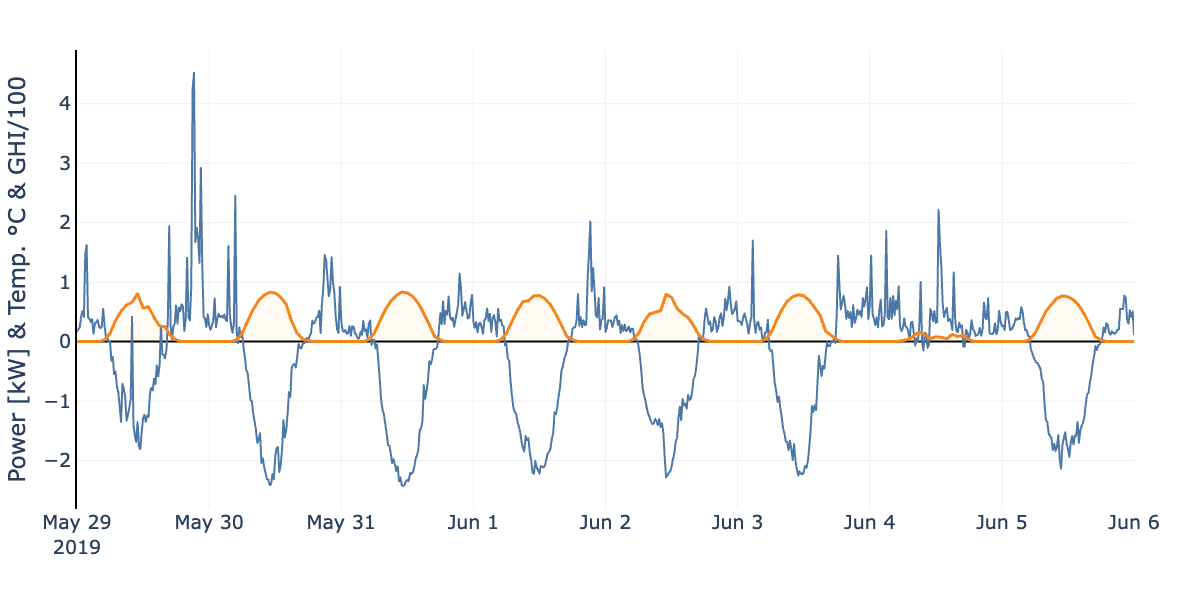

In [84]:
_start = end_training + deltat
_end = _start + nb_horizon * (horizon + deltat)
fig = px.line(df.loc[_start-timedelta(days=1):_end+timedelta(days=1), ["netload_kw", "ghi"]])

fig.data[0].update(line_width=2)
fig.data[-1].update(line_width=3, fill="tozeroy", fillcolor="rgba(255, 127, 14, 0.05)")

fig.update_layout(
    layout,
    height=600,
    width=850,
    showlegend=False,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW] & Temp. °C & GHI/100",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image("results/maison4.svg")

## No regressors

In [96]:
graph = df.copy()
results = predict_n_periods_T(
    graph, start_training, end_training, horizon, deltat, nb_horizon,
    regressors=[],
    seasonality_prior_scale=10.0,
    daily_seasonality="auto")

gof = get_gof(df, results)

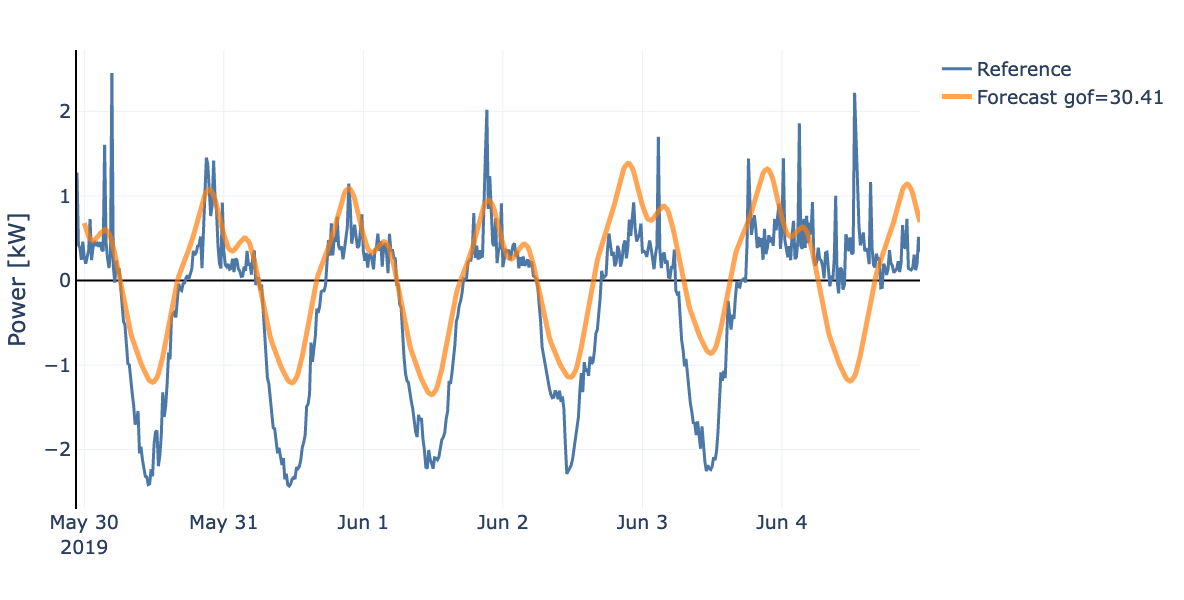

In [97]:
start = end_training
end = start + nb_horizon * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0)

for trace in px.line(results).data:
    fig.add_trace(trace)
    fig.data[-1].update(name=f"Forecast gof={np.round(gof, 2)}",
                        legendgroup=1,
                        line_width=5,
                        line_color="rgba(255, 127, 14, 0.7)")

fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=True,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black'
)
fig.show()

## GHI regressor

In [98]:
graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": 10.0}]

results = predict_n_periods_T(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors,
    seasonality_prior_scale=10.0,
    daily_seasonality="auto")

gof = get_gof(df, results)

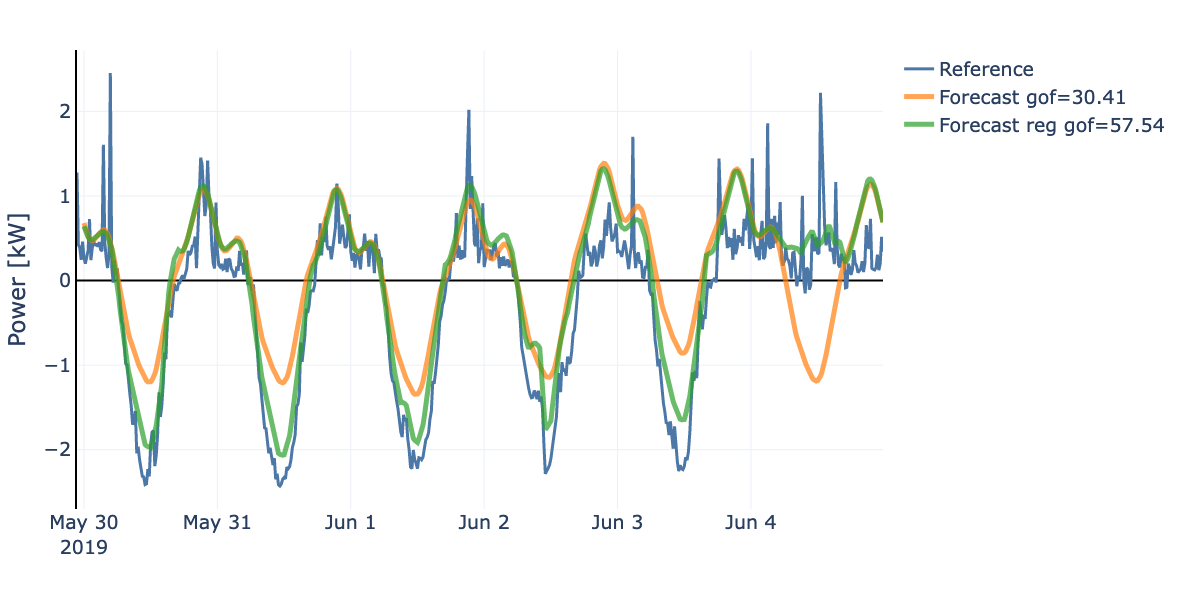

In [99]:
import plotly.graph_objects as go
_fig = go.Figure(fig)


for trace in px.line(results).data:
    _fig.add_trace(trace)
    _fig.data[-1].update(name=f"Forecast reg gof={np.round(gof, 2)}",
                         legendgroup=2,
                         line_width=5,
                         line_color="rgba(44, 160, 44, 0.7)")
_fig.show()

## Auto-regressors

In [100]:
graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": 3.0}]

graph["_datetime"] = graph.index
for hour in range(0, 24):
    graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    regressors.append({"name": f"h{hour}", "prior_scale": 10.0})

nb_lag = list(range(1, 1 + 1))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

results, _ = predict_n_periods_with_autoreg(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors, 
    nb_lag=nb_lag,
    seasonality_prior_scale=1.0,
    daily_seasonality="auto")

gof = get_gof(df, results)

# Forecast:   0%|          | 0/48 [00:00<?, ?it/s]

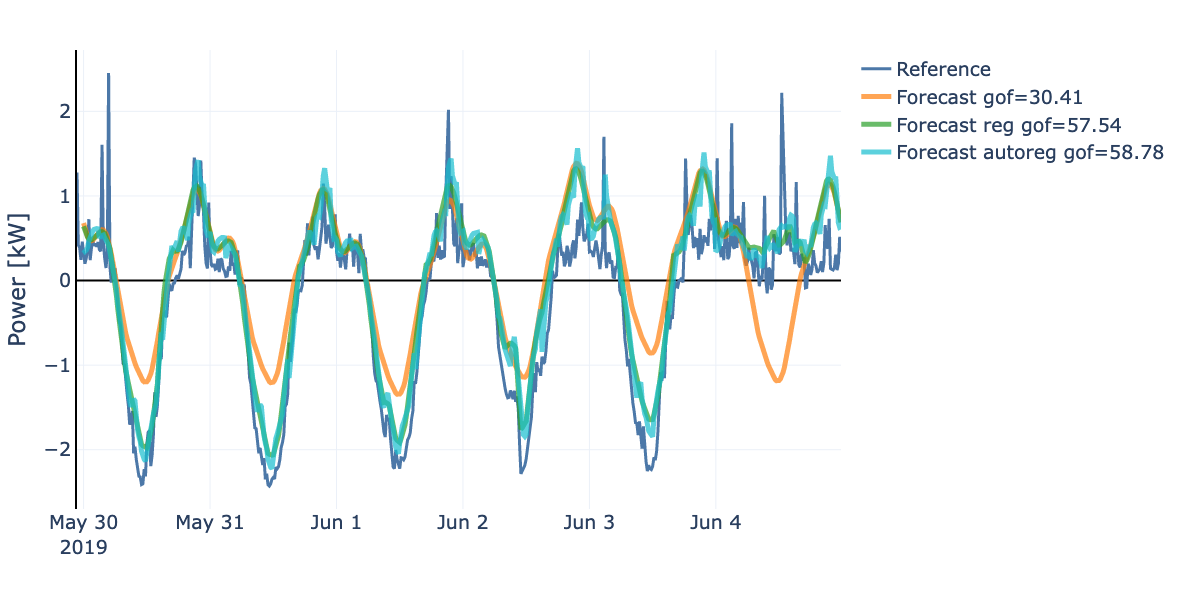

In [101]:
import plotly.graph_objects as go
__fig = go.Figure(_fig)

for trace in px.line(results).data:
    __fig.add_trace(trace)
    __fig.data[-1].update(name=f"Forecast autoreg gof={np.round(gof, 2)}",
                        line_width=5,
                        legendgroup=3,
                        line_color="rgba(23, 190, 207, 0.7)")

__fig.layout.update(xaxis_tickangle=0)
__fig.show()

In [193]:
__fig.write_image("results/_v4_forecasts.svg")

# Calibration procedure for last model

In [173]:
scores = pd.DataFrame()

In [246]:
# Note that better calibration would be to look for all combination such as
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01],
    'seasonality_prior_scale': [0.01, 0.1],
    'machinedede_prior_scale': ["test1", "test2"],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
all_params

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'machinedede_prior_scale': 'test1'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'machinedede_prior_scale': 'test2'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'machinedede_prior_scale': 'test1'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1,
  'machinedede_prior_scale': 'test2'},
 {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01,
  'machinedede_prior_scale': 'test1'},
 {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01,
  'machinedede_prior_scale': 'test2'},
 {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.1,
  'machinedede_prior_scale': 'test1'},
 {'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.1,
  'machinedede_prior_scale': 'test2'}]

In [174]:
def calibrate(df, start_training, end_training, horizon, deltat, nb_horizon):
    gofs = []
    reference = {
         "NB_LAG": 4,
         "PRIOR_GHI": 3.0,
         "PRIOR_LAG": 10.0,
         "PRIOR_HOUR": 10.0,
         "PRIOR_SEASON": 1.0,
         "DAILY_FOURIER": "auto"}
    
    scenarios = [reference]
    for i in range(1, 14 + 1):  #  range(1, 24 + 1)
        scenarios.append(dict(reference))
        scenarios[-1]["NB_LAG"] = i
    
    for i in [1, 5, 8, 10, 15, 20]:
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_GHI"] = i   
  
    for i in [1, 5, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_LAG"] = i 

    for i in [8, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_HOUR"] = i 

    for i in [3]:  #  [3, 5, 8, 10, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_SEASON"] = i         

    #for i in ["auto", 5, 10, 15, 20, 30]:  # no test
    #    scenarios.append(dict(reference))
    #    scenarios[-1]["DAILY_FOURIER"] = i    
    
    graph = df.copy()
    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)
    
    for scenario in tqdm(scenarios, desc="Calibration :"):
        regressors = [{"name": "ghi", "prior_scale": scenario["PRIOR_GHI"]}]
        
        for hour in range(0, 24):
            regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

        nb_lag = list(range(1, scenario["NB_LAG"] + 1))
        for n in nb_lag:
            regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

        results, _ = predict_n_periods_with_autoreg(
            graph, start_training, end_training, horizon, deltat, nb_horizon, 
            regressors, 
            nb_lag=nb_lag,
            seasonality_prior_scale=scenario["PRIOR_SEASON"],
            daily_seasonality=scenario["DAILY_FOURIER"],
            disable_progress_bar=True)

        gofs.append(get_gof(df, results))
    results = pd.DataFrame(data=scenarios)
    results["gof"] = gofs
    return results

In [175]:
_results = calibrate(df, start_training, end_training, horizon, deltat, nb_horizon)
scores = pd.concat([scores, _results], ignore_index=True)
scores.drop_duplicates(keep='first', inplace=True)

Calibration ::   0%|          | 0/27 [00:00<?, ?it/s]

In [176]:
scores.nlargest(columns="gof", n=len(scores))

NB_LAG  PRIOR_GHI  PRIOR_LAG  PRIOR_HOUR  PRIOR_SEASON DAILY_FOURIER  \
0        4        3.0       10.0        10.0           1.0          auto   
17       4        8.0       10.0        10.0           1.0          auto   
16       4        5.0       10.0        10.0           1.0          auto   
7        7        3.0       10.0        10.0           1.0          auto   
15       4        1.0       10.0        10.0           1.0          auto   
24       4        3.0       10.0         8.0           1.0          auto   
20       4       20.0       10.0        10.0           1.0          auto   
25       4        3.0       10.0        15.0           1.0          auto   
22       4        3.0        5.0        10.0           1.0          auto   
23       4        3.0       15.0        10.0           1.0          auto   
18       4       10.0       10.0        10.0           1.0          auto   
3        3        3.0       10.0        10.0           1.0          auto   
19       4       15.0       10.0        10.0           1.0          auto   
2        2        3.0       10.0        10.0           1.0          auto   
8        8        3.0       10.0        10.0           1.0          auto   
21       4        3.0        1.0        10.0           1.0          auto   
6        6        3.0       10.0        10.0           1.0          auto   
5        5        3.0       10.0        10.0           1.0          auto   
10      10        3.0       10.0        10.0           1.0          auto   
1        1        3.0       10.0        10.0           1.0          auto   
26       4        3.0       10.0        10.0           3.0          auto   
14      14        3.0       10.0        10.0           1.0          auto   
9        9        3.0       10.0        10.0           1.0          auto   
13      13        3.0       10.0        10.0           1.0          auto   
12      12        3.0       10.0        10.0           1.0          auto   
11      11        3.0       10.0        10.0           1.0          auto   

          gof  
0   36.625727  
17  35.186566  
16  34.602676  
7   33.824495  
15  33.679341  
24  33.270788  
20  32.987236  
25  32.645499  
22  32.524246  
23  32.395639  
18  31.704535  
3   31.585738  
19  31.530827  
2   31.509975  
8   31.114712  
21  30.564586  
6   30.391376  
5   29.244996  
10  28.659139  
1   27.889147  
26  27.197283  
14  26.394404  
9   25.407157  
13  25.267051  
12  23.210308  
11  21.644166

# Last model with best calibration look at uncertainties

In [93]:
graph = df.copy()
regressors = [{"name": "ghi", "prior_scale": 3.0}]

graph["_datetime"] = graph.index
for hour in range(0, 24):
    graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    regressors.append({"name": f"h{hour}", "prior_scale": 10.0})

nb_lag = list(range(1, 1 + 1))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

results, mygam = predict_n_periods_with_autoreg(
    graph, start_training, end_training, horizon, deltat, nb_horizon, 
    regressors, 
    nb_lag=nb_lag,
    seasonality_prior_scale=1.0,
    daily_seasonality="auto",
    uncertainties=False, # 1000
    reccord_raw=True)

gof = get_gof(df, results)

# Forecast:   0%|          | 0/48 [00:00<?, ?it/s]

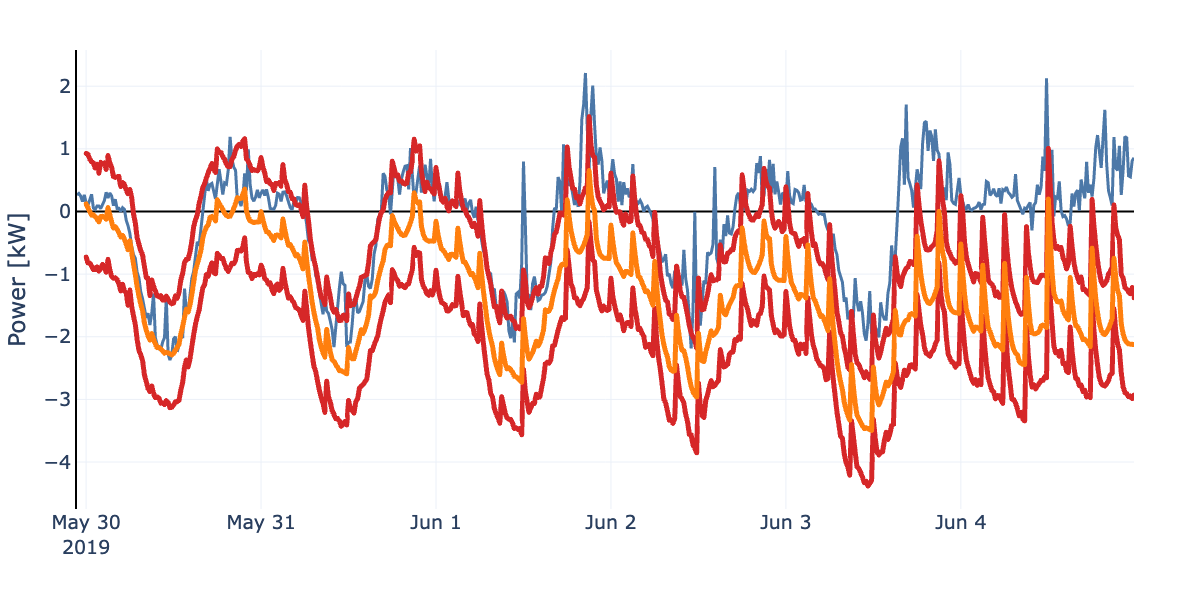

In [57]:
start = end_training
end = start + nb_horizon * (deltat + horizon)

fig = px.line(df.loc[start-timedelta(hours=1):end, "netload_kw"])
fig.data[-1].update(line_width=3, name="Reference", legendgroup=0)

graph = mygam.raw.copy()
graph.set_index("ds", inplace=True, drop=True)

colors = ["rgba(214, 39, 40, 1.0)", "rgba(214, 39, 40, 1.0)", "rgba(255, 127, 14, 1.0)"]
for i, trace in enumerate(px.line(graph[["yhat_lower", "yhat_upper", "yhat"]]).data):
    fig.add_trace(trace)
    fig.data[-1].update(line_width=5,
                        line_color=colors[i])

fig.data[-2].update(fill="tonexty", fillcolor="rgba(214, 39, 40, 0.05)")
    
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=False,
    legend_title="",
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0
)
fig.show()

In [237]:
fig.write_image("results/_v4_uncertainties.svg")

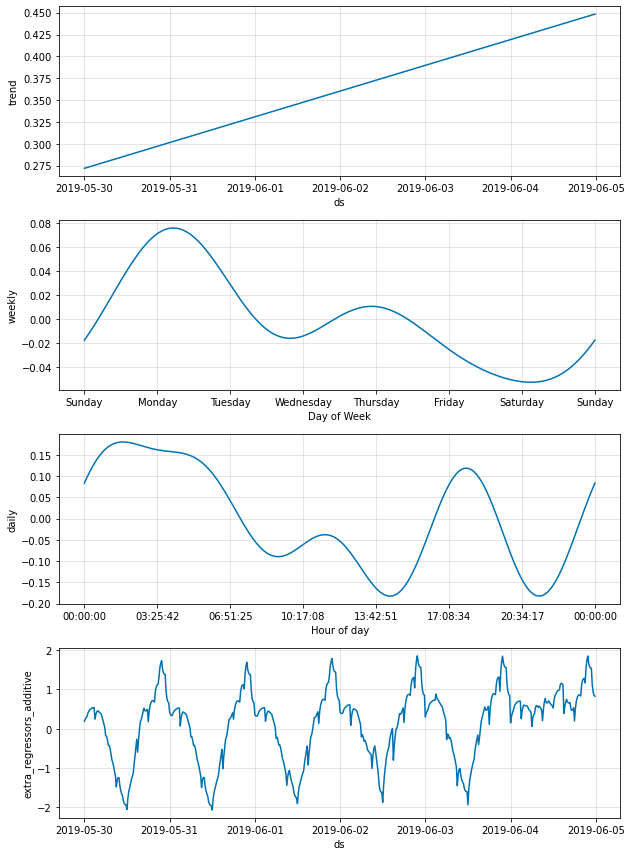

In [94]:
from prophet.plot import plot_components_plotly, plot_components
#fig = plot_components_plotly(mygam._model, mygam.raw)
fig = plot_components(mygam._model, mygam.raw)